[*********************100%%**********************]  1 of 1 completed


/var/folders/81/9l4tcsf92m14nlrr3rvwnky00000gn/T/ipykernel_15875/1376592306.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.date_range(start=start_date, periods=len(df), freq='D')
11:54:32 - cmdstanpy - INFO - Chain [1] start processing
11:54:32 - cmdstanpy - INFO - Chain [1] done processing
/Users/chandansatvik/Desktop/ANACONDA/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chandansatvik/Desktop/ANACONDA/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provi

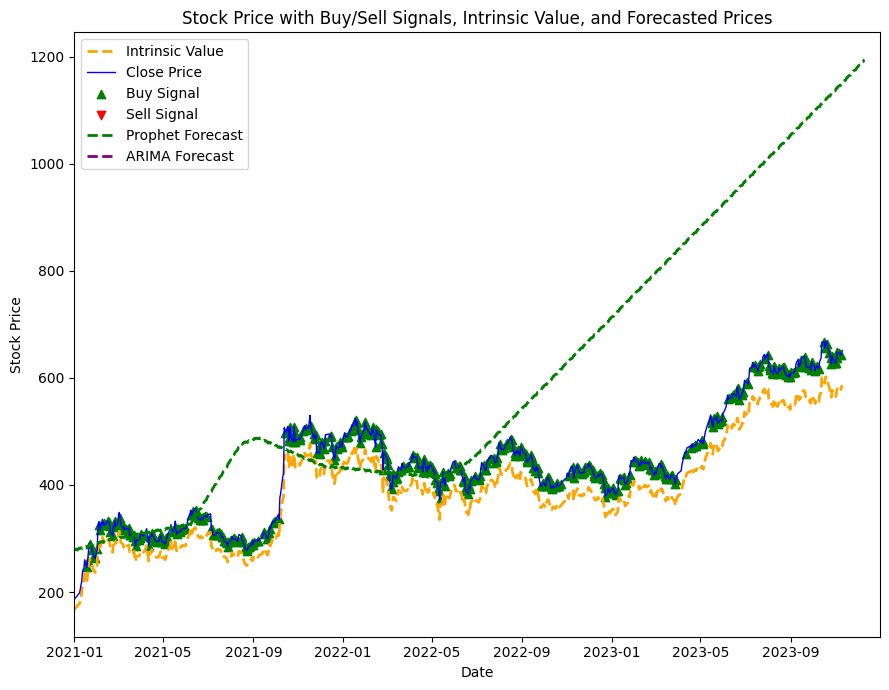

Right Price to Buy: 642.5499877929688
Right Price to Sell: None
No recent sell signals. Hold for potential further profit.
Prophet Forecasted Price: 1194.270757441245
ARIMA Forecasted Price: 651.2750458425904


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Download Data
ticker = 'TATAMOTORS.NS'
start_date = '2021-01-01'
end_date = '2023-12-31'

# Using Yahoo Finance API to get the data
data = yf.download(ticker, start=start_date, end=end_date)

# Preprocessing
data['P/E'] = data['Close'] / data['Close'].shift(1)
data['P/B'] = data['Close'] / data['Close'].shift(1)
data['Change'] = data['Close'].pct_change()
data['Return'] = data['Close'].pct_change()
data['PB Ratio'] = data['Close'] / data['Close'].shift(1)
data['Growth Score'] = data['Close'].pct_change().rolling(window=5).mean()
data['Durability Score'] = data['Close'].pct_change().rolling(window=20).mean()
data['Momentum Score'] = data['Close'].pct_change().rolling(window=30).mean()
data['Profitability Score'] = data['P/E'].rolling(window=5).mean()
data['Red Flags'] = data['Close'].rolling(window=10).max() - data['Close']

# Intrinsic value (modify this calculation as needed)
intrinsic_value = data['Close'] * 0.9

# Using machine learning to generate buy or sell calls
data['Buy'] = np.nan
data.loc[data['Red Flags'] > 0.05, 'Buy'] = data['Close'][data['Red Flags'] > 0.05]
data['Sell'] = np.nan
data.loc[data['Red Flags'] < -0.05, 'Sell'] = data['Close'][data['Red Flags'] < -0.05]

# Feature Engineering
features = ['P/E', 'P/B', 'Change', 'Return', 'PB Ratio', 'Growth Score', 'Durability Score', 'Momentum Score', 'Profitability Score']
X = data[features].dropna()
y = data['Close'].shift(-1).dropna()

# Ensure X and y have the same length
min_length = min(len(X), len(y))
X = X.iloc[:min_length]
y = y.iloc[:min_length]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using XGBoostRegressor for prediction
xgb_model = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
predictions = best_xgb_model.predict(X_test)

# Forecasting the stock price using Prophet
df = data[['Close']]
df.columns = ['y']
df['ds'] = pd.date_range(start=start_date, periods=len(df), freq='D')

# Using Prophet
prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365)
forecast_prophet = prophet.predict(future)

# Using SARIMAX (ARIMA)
model_arima = SARIMAX(df['y'], order=(5, 1, 0))
model_fit = model_arima.fit(disp=0)
forecast_arima = model_fit.get_forecast(steps=365)

# Plotting the stock price along with buy and sell calls, intrinsic value, and forecasted prices
plt.figure(figsize=(9, 7))

# Plot intrinsic value
plt.plot(intrinsic_value.index, intrinsic_value, label='Intrinsic Value', linestyle='--', linewidth=2, color='orange')

# Plot stock price
plt.plot(data['Close'].index, data['Close'], label='Close Price', linewidth=1, color='blue')

# Scatter points for Buy and Sell signals
plt.scatter(data.index, data['Buy'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(data.index, data['Sell'], marker='v', color='r', label='Sell Signal', alpha=1)

# Plot forecasted prices
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], linestyle='--', label='Prophet Forecast', linewidth=2, color='green')
plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean.values, linestyle='--', label='ARIMA Forecast', linewidth=2, color='purple')

plt.title('Stock Price with Buy/Sell Signals, Intrinsic Value, and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Set x-axis limits based on start date and end date
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Adjust spacing
plt.tight_layout()

plt.show()

# Print the right price to buy and sell
recent_buy_price = data['Buy'].dropna().iloc[-1] if not data['Buy'].dropna().empty else None
recent_sell_price = data['Sell'].dropna().iloc[-1] if not data['Sell'].dropna().empty else None

print(f"Right Price to Buy: {recent_buy_price}")
print(f"Right Price to Sell: {recent_sell_price}")

if recent_sell_price is None:
    print("No recent sell signals. Hold for potential further profit.")

# Print the forecasted price
print(f"Prophet Forecasted Price: {forecast_prophet['yhat'].iloc[-1]}")
print(f"ARIMA Forecasted Price: {forecast_arima.predicted_mean.iloc[-1]}")
